# HEART RATE ESTIMATION

Seismocardiography([SCG](https://www.ncbi.nlm.nih.gov/pubmed/24111357)) is a very promising technique to measure Heart Rate (HR) and Respiratory Rate (RR) with the detector positioned above sternum. It is generally based on accelerometer and gyroscope readings or a combination of them. 

Ballistocardiography([BCG](https://en.wikipedia.org/wiki/Ballistocardiography)) is an another technique to estimate heart and respiratory rate with combination of both accelerometer and gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., accelerometer platform mounted under the slats of the bed).   
  
MuSe(Multi-Sensor miniaturized, low-power, wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provide by [221e](https://www.221e.com). In the context of this project, It allows to record the inertial data necessary for the estimation of SCG and BCG.

The goal of this assignment is to estimate the heart rate of an healthy subject, given linear acceleration and angular velocity measurements recorded by using the aforementioned MuSe platform. 
The study must be performed on two datasets: the first is the compulsory one (**center_sternum.txt**) while the second is left at the discretion of the group, among those made available for the assignment.

**N.B: Remember that normal beat is around [40-100] bpm.**


## Dataset

The data is provided in .txt file. During this study two healthy subjects were involved with their informed consent. The first dataset was recorded on one subject, while all the other datasets were recorded on the second subject. 

This is the first mandatory file:

* **center_sternum.txt**: MuSe placed on the center of the sternum. The subject was lying supine on his left and right side, respectively. 


Choose one of the following files in order to complete the task.

1. **1_Stave_supine_static.txt**: Sensor placed on a bed stave, under the mattress at the level of the chest. The subject was lying supine on his left and right side. 
* **2_Mattress_supine.txt**: Sensor placed on the mattress, near one corner but not under the pillow. The subject laid in the same position as above. 
* **3_Subject_sitting_chair.txt**: Sensor placed on the desk: the subject, sitting on a chair, leaned forearms and hands on the desk. 
* **4_Chest_sweater.txt**: Sensor placed on the subject chest directly on a sweater. 
* **5_Under_chair.txt**: Subject sitting on a chair, sensor placed under the seat of the chair. 

All .txt files give 16 columns index, in particular: 

* Log Freq stands for the acquisition  in Hz (i.e., sampling interval is constant).
* AccX, AccY, AccZ are the measured magnitude of linear acceleration along each axis.
* GyroX, GyroY, GyroZ are the measured magnitude of angular velocity along each axis.
* MagnX, MagnY, MagnZ are the measured magnitude of magnetic field along each axis.
* qw, qi, qj, qk are the quaternion components, representing the spatial orientation of the Muse system.

Each dataset includes, in addition to the data, one file containing the adopted configuration of the MuSe(**README1.txt** for the first measurement, and in **README_5.txt** for the other measurement).
 


## Assignment



1. Data preparation:

    1.1. Load the txt file and select only the columns you are interesting in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )
    
    1.2. Plot selected data in function of time and choose a properly time window over which to perform the analysis. Pay attention on time rappresentation and the measurament unit.
    
    1.3. In order to make an appropiate work, decide if take care about some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.  


    
2. Time and frequency analysis:

    2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.
    
    2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use this step in order to properly design the filters in the following step. 



3. Filter:
    
    Implement your own filter, trying to extrapolate heart rate signal. Hint:
    
    (a) Directly from Fourier Analysis, antitrasform data looking for the most interesting frequency band.
    
    (b) Choose the appropriate Lowpass/Bandpass/Highpass filter.
    
    (c) Wavelet trasform (a powerfull instrument that make a time and frequency analysis of signal).
    
    (d) Find another method by yourselves.
    
    Motivate your choice.
    
    
4. Metrics:

    4.1. Heart Beat Per Minute(BPM): extrapolate BPM, make an histogram of the result. Does it follow a partiular distribution? 
    
    4.2. Heart Rate Variability(HRV): extrapolate HRV, explain why this parameter is important, and plot the results.



5. (OPTIONAL) Algorithm: Elaborate a simple algorithm to extrapolate heart beat even when filter failed (e.g. look at particular threshold...).  



6. Conclusion: 

    Summarise the obtained results, in particular making a comparison between the two files analysed. Highlight limitation and critical issues encountered during the work, motivating the most relevant contribution given by your solution.




**N.B: Indicate the contribution, to achieving the result, of each member of the group.**


## Load the required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
#empty cell, do not delete, just edit

In [3]:
#empty cell, do not delete, just edit

In [4]:
#empty cell, do not delete, just edit

## Read the data and correct it with respect to the calibration

In these cells I read the data w.r.t. the calibration and i've added a time column (by taking steps of 1/samplingfrequency)

In [5]:
df = pd.read_csv('center_sternum.txt',sep='\t')  

#This data isn't correct, needs to be calibrated

gyro_offset = np.array([-2.242224,2.963463,-0.718397])
acc_calibration = np.array([[1.000966,-0.002326418,-0.0006995499],
                    [-0.002326379,0.9787045,-0.001540918],
                    [-0.0006995811,-0.001540928,1.00403]])
acc_offset = np.array([-3.929942,-13.74679,60.67546])
magn_calibration=np.array([[0.9192851,-0.02325168,0.003480837],
                   [-0.02325175,0.914876,0.004257396],
                   [0.003481006,0.004257583,0.8748001]])
magn_offset=np.array([-95.67974,-244.9142,17.71132])

df[['GyroX','GyroY','GyroZ']] = df[['GyroX','GyroY','GyroZ']] + gyro_offset.T
df[['AccX','AccY','AccZ']] = np.dot(df[['AccX','AccY','AccZ']],acc_calibration.T) + acc_offset.T
df[['MagnX','MagnY','MagnZ']] = np.dot(df[['MagnX','MagnY','MagnZ']],magn_calibration.T) + magn_offset.T

#Add time column by taking time steps of 1/logFreq

df['Time'] = np.arange(0, len(df['Log Freq']))/df['Log Freq'][0]
display(df)

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk,Time
0,5,200,1576222772,943.007996,410.325442,130.264244,-9.066652,-11.280817,0.686183,-502.261441,-683.404962,-141.669690,0.792622,0.254952,-0.553850,-0.000031,0.000
1,5,200,1576222772,965.209969,363.380701,148.635086,3.940982,-9.326617,-8.687863,-502.257960,-683.400705,-140.794890,0.736461,0.275124,-0.617969,0.006806,0.005
2,5,200,1576222772,985.689106,356.065246,138.465450,9.467696,-1.998369,-8.168779,-502.257960,-683.400705,-140.794890,0.729465,0.275246,-0.626118,0.009827,0.010
3,5,200,1576222772,950.852176,393.026437,148.047237,15.635636,5.482547,-6.703130,-502.207976,-685.226199,-139.928605,0.723413,0.277200,-0.632221,0.011383,0.015
4,5,200,1576222772,968.040164,402.461108,159.595720,22.979146,8.368043,3.296870,-502.207976,-685.226199,-139.928605,0.721948,0.280007,-0.632679,0.010193,0.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16501,5,200,1576222847,954.849739,269.000099,5.047576,-0.578102,5.268807,-1.390153,-539.805161,-644.743591,-96.144764,0.650810,0.379162,-0.636402,0.166356,82.505
16502,5,200,1576222847,951.006879,266.016847,9.709647,-0.761308,5.452013,-1.420687,-539.778428,-645.654210,-95.274222,0.650239,0.379803,-0.636708,0.165960,82.510
16503,5,200,1576222847,963.711402,268.397270,-4.573267,-1.127720,6.337509,-1.619160,-539.778428,-645.654210,-95.274222,0.649365,0.380627,-0.637227,0.165502,82.515
16504,5,200,1576222847,961.972293,278.538659,3.067677,-1.539934,6.627585,-2.306183,-540.740736,-643.796949,-94.394388,0.648973,0.381329,-0.637348,0.164953,82.520


In [6]:
#empty cell, do not delete, just edit

In [7]:
#empty cell, do not delete, just edit

In [8]:
#empty cell, do not delete, just edit

## Plot the data and choose time frame

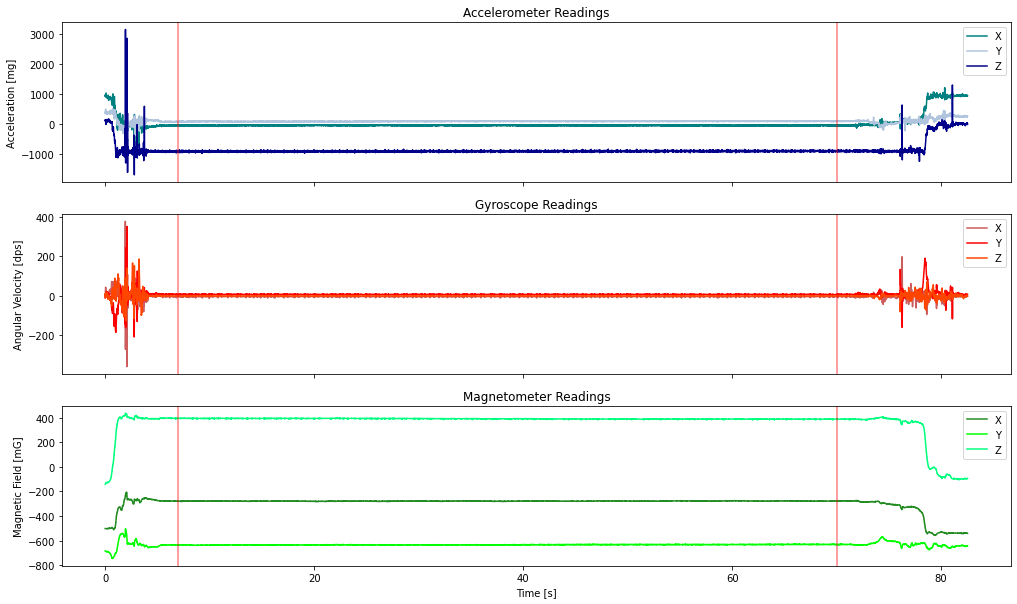

In [9]:
(fig, (ax1,ax2,ax3)) = plt.subplots(3,1,figsize=(17,10), sharex=True)

ax1.set_title('Accelerometer Readings')
ax1.plot(df['Time'], df['AccX'], color= 'teal',label='X')
ax1.plot(df['Time'], df['AccY'], color= 'lightsteelblue',label='Y')
ax1.plot(df['Time'], df['AccZ'], color= 'darkblue',label='Z')
ax1.axvline(x = 7, color = 'red', alpha = 0.5)
ax1.axvline(x = 70, color = 'red', alpha = 0.5)
ax1.set_ylabel('Acceleration [mg]')
ax1.legend()

ax2.plot(df['Time'], df['GyroX'],color = 'indianred', label='X')
ax2.plot(df['Time'], df['GyroY'],color = 'red' , label='Y')
ax2.plot(df['Time'], df['GyroZ'],color = 'orangered' , label='Z')
ax2.set_title('Gyroscope Readings')
ax2.axvline(x = 7, color = 'red', alpha = 0.5)
ax2.axvline(x = 70, color = 'red', alpha = 0.5)
ax2.set_ylabel('Angular Velocity [dps]')
ax2.legend()

ax3.plot(df['Time'], df['MagnX'],color = 'forestgreen' , label='X')
ax3.plot(df['Time'], df['MagnY'], color = 'lime', label='Y')
ax3.plot(df['Time'], df['MagnZ'], color = 'springgreen', label='Z')
ax3.set_title('Magnetometer Readings')
ax3.axvline(x = 7, color = 'red', alpha = 0.5)
ax3.axvline(x = 70, color = 'red', alpha = 0.5)
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Magnetic Field [mG]') 
ax3.legend()

plt.show()

In [10]:
#empty cell, do not delete, just edit

In [11]:
#empty cell, do not delete, just edit

In [12]:
#empty cell, do not delete, just edit

## Remove unimportant columns and limit time between thresholds

In [13]:
df_time_frame = df.loc[(df['Time'] >= 7) & (df['Time'] <= 70)] #limit analysis in specified time frame
df_time_frame= df_time_frame.drop(['Log Mode', 'Log Freq', 'Timestamp','qw', 'qi', 'qj', 'qk', 'Time', 'MagnX', 'MagnY', 'MagnZ'], axis=1) #drop uninmportant columns
display(df_time_frame)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
1400,-40.966811,97.029054,-875.184185,-3.845277,6.826058,-1.466489
1401,-34.987088,86.098363,-919.513010,-3.723140,6.642852,-1.909237
1402,-40.518149,94.134202,-895.697231,-3.692606,6.993997,-1.603893
1403,-35.181772,86.193470,-903.405417,-3.417797,7.207738,-1.802366
1404,-31.341134,88.631706,-903.044484,-3.555201,7.268807,-1.985573
...,...,...,...,...,...,...
13996,-34.443708,104.012984,-884.386623,-5.417797,6.322242,-1.497023
13997,-36.395733,103.541515,-885.425685,-5.234590,6.642852,-1.268015
13998,-26.245083,99.049690,-891.489056,-5.265125,6.749723,-1.283282
13999,-42.264295,104.980254,-880.401686,-5.097186,6.383310,-1.603893


In [14]:
#empty cell, do not delete, just edit

In [15]:
#empty cell, do not delete, just edit

In [16]:
#empty cell, do not delete, just edit

# STATISTICAL QUANTITIES

In these cells I've displayed the statistical quantities and centered the data. Ideally we would now apply a PCA procedure on the dataset

In [17]:
statistics = pd.DataFrame({
    'mean'  : df_time_frame.mean(),
    'median': df_time_frame.median(),
    'variance': df_time_frame.var(),
    'standard deviation': df_time_frame.std(),
    '25% percentile' : df_time_frame.quantile(q=0.25),
    '75% percentile': df_time_frame.quantile(q=0.75)}).T

display(statistics)

centered_df = (df_time_frame - statistics.iloc[0])

standardized_df = centered_df/statistics.iloc[3]

display(standardized_df)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
mean,-34.301107,100.672668,-892.751709,-4.328942,6.645621,-1.585198
median,-34.255264,100.925927,-893.136026,-4.394896,6.597051,-1.573359
variance,50.283779,30.225341,214.154767,2.100338,0.538998,0.156231
standard deviation,7.091106,5.497758,14.634028,1.449254,0.734165,0.395261
25% percentile,-38.951062,97.261279,-901.522903,-4.944514,6.230639,-1.832901
75% percentile,-29.585315,104.273711,-884.748964,-3.707873,6.963463,-1.329084


,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
1400,-0.940009,-0.662745,1.200457,0.333734,0.245772,0.300333
1401,-0.096738,-2.650954,-1.828704,0.418009,-0.003771,-0.819810
1402,-0.876738,-1.189297,-0.201279,0.439078,0.474521,-0.047297
1403,-0.124193,-2.633655,-0.728009,0.628699,0.765655,-0.549429
1404,0.417421,-2.190159,-0.703345,0.533889,0.848837,-1.012938
...,...,...,...,...,...,...
13996,-0.020110,0.607578,0.571619,-0.751321,-0.440472,0.223082
13997,-0.295388,0.521821,0.500616,-0.624906,-0.003771,0.802466
13998,1.136074,-0.295207,0.086282,-0.645976,0.141797,0.763840
13999,-1.122983,0.783517,0.843925,-0.530096,-0.357292,-0.047297


In [18]:
#empty cell, do not delete, just edit

In [19]:
#empty cell, do not delete, just edit

In [20]:
#empty cell, do not delete, just edit

# PCA

In [21]:
import scipy.linalg as la

cov = np.cov(standardized_df.T) 
print('Covariance matrix is: \n')
print(cov)
l, V = la.eig(cov)
print('\n')
print(np.real_if_close(l))

var = []
for i in range(len(l)):
    var.append(np.real_if_close(l[i]/l.sum()))
for i in range(len(var)):
    print('The direction described by the eigenvector', V[:,i], 'with eigenvalue', np.round(np.real_if_close(l[i]),5), 'accounts for', np.round(var[i]*100,5), '% of the dataset variance.')

Covariance matrix is: 

[[ 1.         -0.18258906 -0.40534598  0.21207383  0.00694783  0.02527068]
 [-0.18258906  1.          0.17543359 -0.05200114  0.00194328 -0.10264916]
 [-0.40534598  0.17543359  1.         -0.07794268  0.11182493  0.0170906 ]
 [ 0.21207383 -0.05200114 -0.07794268  1.          0.39781266  0.35024432]
 [ 0.00694783  0.00194328  0.11182493  0.39781266  1.          0.42702172]
 [ 0.02527068 -0.10264916  0.0170906   0.35024432  0.42702172  1.        ]]


[1.83721489 1.5302441  0.9071801  0.64092376 0.55171807 0.53271907]
The direction described by the eigenvector [ 0.27405557 -0.18872542 -0.14437288  0.5633284   0.5203014   0.52950948] with eigenvalue 1.83721 accounts for 30.62025 % of the dataset variance.
The direction described by the eigenvector [-0.56817184  0.35661564  0.62363209  0.04131969  0.33332625  0.21971653] with eigenvalue 1.53024 accounts for 25.50407 % of the dataset variance.
The direction described by the eigenvector [-0.28504266 -0.87742433  0.2088

In [22]:
#empty cell, do not delete, just edit

In [23]:
#empty cell, do not delete, just edit

In [24]:
#empty cell, do not delete, just edit

## Now we rotate the data in the new base, thus taking a linear combination of physical quantities. We then drop the last two columns.

In [25]:
rotated_data = np.dot(V.T, standardized_df.T) #bring the dataset in the eigenvector basis
dataset_rotated = pd.DataFrame(rotated_data.T, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
dataset_rotated = dataset_rotated.drop(['PC5','PC6'], axis = 1)
display(dataset_rotated)

,PC1,PC2,PC3,PC4
0,0.169055,1.208085,1.065950,-0.512519
1,0.537223,-2.194957,1.702861,-0.209951
2,0.482429,0.114413,1.112805,-0.128584
3,1.029715,-1.162177,1.896885,-0.787033
4,0.835325,-1.374400,1.287462,-1.106719
...,...,...,...,...
12596,-0.736997,0.455727,-0.156505,0.300455
12597,-0.180785,0.815358,0.048987,0.672151
12598,0.468945,-0.508551,0.263527,0.257679
12599,-1.087031,1.292370,-0.052567,0.266607


In [26]:
#empty cell, do not delete, just edit

In [27]:
#empty cell, do not delete, just edit

In [28]:
#empty cell, do not delete, just edit

## By using the first 4 principal componenets we retain around 80% of the variability (please check PCA is correct) --> We now apply FFT and look for the peaks of each principal component.

69.51829219903183 beats per minute


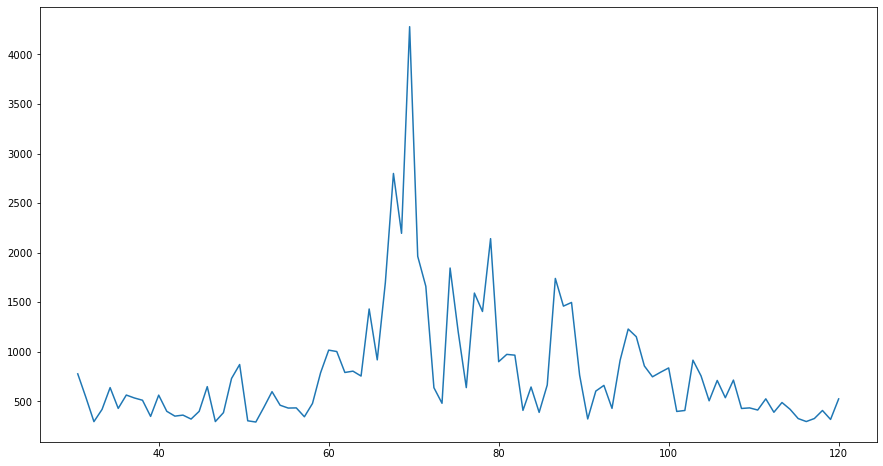

In [29]:
from scipy import signal


min_f = 30/60  #minimum of athletes is 30 beats per minute
max_f = 120/60 #maximum (sustainable) is around 120 beats per minimum

sample_freq = 200

# FFT
PC1_FFT = np.abs(np.fft.rfft(dataset_rotated['PC1']))
PC2_FFT = np.abs(np.fft.rfft(dataset_rotated['PC2']))
PC3_FFT = np.abs(np.fft.rfft(dataset_rotated['PC3']))
PC4_FFT = np.abs(np.fft.rfft(dataset_rotated['PC4']))

freq_FFT = np.fft.rfftfreq(d=1/sample_freq, n=len(dataset_rotated['PC1']))

X = []
YPC1 = []
YPC2 = []
YPC3 = []
YPC4 = []

for i in range(len(PC1_FFT)):
    if freq_FFT[i]<=max_f and freq_FFT[i]>=min_f:
        X.append(freq_FFT[i])
        YPC1.append(PC1_FFT[i])
        YPC2.append(PC2_FFT[i])
        YPC3.append(PC3_FFT[i])
        YPC4.append(PC4_FFT[i])

# The heartbeat is given by the sum of the different components
total_FFT = np.array(YPC1) + np.array(YPC2) + np.array(YPC3) + np.array(YPC4)
fig2, ax1 = plt.subplots(figsize=(15, 8))
ax1.plot(np.array(X)*60, total_FFT, label='Sum of FFT')


# Find the value of the highest peak is
idx_max = np.argmax(total_FFT)
peak_freq = X[idx_max]*60
print(peak_freq, "beats per minute")



In [30]:
# A) carmen empty cell, do not delete, just edit

In [31]:
# B) alessandro empty cell, do not delete, just edit

In [32]:
# C) nico empty cell, do not delete, just edit

In [33]:
# D) marco empty cell, do not delete, just edit

# FILTER

## (a) Directly from Fourier Analysis, antitrasform data looking for the most interesting frequency band.

In [34]:
#empty cell, do not delete, just edit

In [35]:
#empty cell, do not delete, just edit

In [36]:
#empty cell, do not delete, just edit

In [37]:
#empty cell, do not delete, just edit

In [38]:
#empty cell, do not delete, just edit

In [39]:
#empty cell, do not delete, just edit

## (b) Choose the appropriate Lowpass/Bandpass/Highpass filter.

In [40]:
#empty cell, do not delete, just edit

In [41]:
#empty cell, do not delete, just edit

In [42]:
#empty cell, do not delete, just edit

In [43]:
#empty cell, do not delete, just edit

In [44]:
#empty cell, do not delete, just edit

In [45]:
#empty cell, do not delete, just edit

## (c) Wavelet trasform (a powerfull instrument that make a time and frequency analysis of signal).

In [53]:
from scipy import signal
import pywt
import copy

In [65]:
def wavelet_transform(signal, levels, waveletType):
    # first do the transform using the input signal with the wavelet type and levels inputed
    transformCoeffs = pywt.wavedec(signal, waveletType, level=levels)
    #print(transformCoeffs)
    
    time = np.array(df['Time'])
    result = np.zeros((levels+1, len(time)))
    print(len(signal), len(time))
    
    # 
    for i in range(levels+1):
        coeffs = copy.deepcopy(transformCoeffs)
        for j in range(levels+1):
            # Loop over every other level and set to zero
            if(i!=j):
                coeffs[j] = np.zeros_like(coeffs[j])
            
        #add the inverse wavelet of the level i to the corresponding result row
        result[i] = pywt.waverec(coeffs, waveletType)
    
    for level in range(levels+1):
        # Plot each level
        plt.plot(time, result[level])
        plt.title(f'Wavelet Transform for level {level}')
        plt.show()
        
    '''Do transform, loop over every level and set all other levels to zero and add to the final 
        coefficients array, removing noise from other leverls. Then loop through each level again 
        and plot the inverse wavelet.
        
    '''

wavelet_transform(np.array(dataset_rotated['PC1']), 4, 'sym4')

12601 16506


ValueError: could not broadcast input array from shape (12602) into shape (16506)

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

## (d) Find another method by yourselves.

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

## Motivate your choice.

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

# METRICS

## 4.1. Heart Beat Per Minute(BPM): extrapolate BPM, make an histogram of the result. Does it follow a partiular distribution? 

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

## 4.2. Heart Rate Variability(HRV): extrapolate HRV, explain why this parameter is important, and plot the results.

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

# (OPTIONAL) Algorithm: Elaborate a simple algorithm to extrapolate heart beat even when filter failed (e.g. look at particular threshold...).

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

# CONCLUSIONS

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit

In [ ]:
#empty cell, do not delete, just edit